# **Product Vision Search:** Build a Product recognition engine in one hour
This example is using a Kaggle dataset for product recognition. The goal is to extract a csv for bulk import in Product Vision Search  
**Useful links:**  
https://github.com/zinjiggle/google-product-search-simple-ui  
https://github.com/GoogleCloudPlatform/python-docs-samples/tree/master/vision/cloud-client/product_search

## 0. Install Google Cloud Vision library

In [ ]:
#pip install google-cloud-vision

Init with your own project

In [1]:
project_id='pod-fr-retail'
location='europe-west1'
product_set='kaggle_shoes'
bucket_name="pod-fr-retail-kaggle"
gcs_bucket="gs://"+bucket_name+"/"

In [2]:
from google.cloud import vision_v1

## 1. Check index time of product sets 

In [3]:
import time
from google.cloud import vision_v1
client = vision_v1.ProductSearchClient()
parent = client.location_path(project_id, location)
name = client.product_set_path(project_id, location, product_set)
for element in client.list_product_sets(parent):
    #print(element)
    print('Index name:', element.name)
    print('Last index:',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(element.index_time.seconds)))
    print('------')
    pass


Index name: projects/pod-fr-retail/locations/europe-west1/productSets/kaggle_shoes
Last index: 2022-10-24 19:19:29
------
Index name: projects/pod-fr-retail/locations/europe-west1/productSets/pvs_shoes
Last index: 2022-10-24 19:19:29
------


## 2. Search a product in your catalog

In [4]:
from google.cloud import vision
from google.cloud import storage
from IPython.display import Image, display
import pandas as pd

def get_image(uri):
    client_storage = storage.Client() # Implicit environment set up
    bucket = uri.split("/")[2]
    object_name = "/".join(uri.split("/")[3:])
    # with explicit set up:
    # client = storage.Client.from_service_account_json('key-file-location')
    bucket = client_storage.get_bucket(bucket)
    blob = bucket.get_blob(object_name)
    return(Image(blob.download_as_bytes()))
    
def get_similar_products_file(
        project_id,
        location,
        product_set_id,
        product_category,
        file_path,
        filter,
        max_results
):
    """Search similar products to image.
    Args:
        project_id: Id of the project.
        location: A compute region name.
        product_set_id: Id of the product set.
        product_category: Category of the product.
        file_path: Local file path of the image to be searched.
        filter: Condition to be applied on the labels.
                Example for filter: (color = red OR color = blue) AND style = kids
                It will search on all products with the following labels:
                color:red AND style:kids
                color:blue AND style:kids
        max_results: The maximum number of results (matches) to return. If omitted, all results are returned.
    """
    # product_search_client is needed only for its helper methods.
    
    image_annotator_client = vision.ImageAnnotatorClient()

    # Read the image as a stream of bytes.
    with open(file_path, 'rb') as image_file:
        content = image_file.read()

    # Create annotate image request along with product search feature.
    image = vision.types.image_annotator_pb2.Image(content=content)
    product_search_client = vision.ProductSearchClient()
    # product search specific parameters
    product_set_path = product_search_client.product_set_path(
        project=project_id, location=location,
        product_set=product_set_id)
    product_search_params = vision.types.ProductSearchParams(
        product_set=product_set_path,
        product_categories=[product_category],
        filter=filter)
    image_context = vision.types.ImageContext(
        product_search_params=product_search_params)

    # Search products similar to the image.
    response = image_annotator_client.product_search(
        image,
        image_context=image_context,
        max_results=max_results
    )
    
    index_time = response.product_search_results.index_time
    print('Last Product index:',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(index_time.seconds)))

    results = response.product_search_results.results
    return results

def display_results(results,file_path):
    print('Search results for : \n')
    display(Image(file_path))
    i=0
    print('\n')
    for result in results:
        print('-----Result ', i, ' ------')
        product_search_client = vision.ProductSearchClient()
        image = product_search_client.get_reference_image(name=result.image)
        display(get_image(image.uri))
        product = result.product
        print('Score(Confidence): {}'.format(result.score))
        print('Image name: {}'.format(result.image))
        print('Image URI: {}'.format(image.uri))
        print('Product name: {}'.format(product.name))
        print('Product display name: {}'.format(
            product.display_name))
        print('Product description: {}\n'.format(product.description))
        print('Product labels: \n')
        df=[]
        for p in product.product_labels:
            df.append([p.key, p.value])
        print(pd.DataFrame(df, columns=["Key", "Value"]))
        i=i+1
        print('\n')

def analyse_results(results, file_path):
    df=[]
    print('Search results for : \n')
    display(Image(file_path))
    i=0
    print('\n')
    for result in results:
        if result.score>0.1:
            for p in result.product.product_labels:
                df.append([p.key, p.value])
    data=pd.DataFrame(df, columns=["Category Level", "Category Name"])
    cnt_per_key =  data.groupby(["Category Level", "Category Name"])["Category Name"].count().reset_index(name="count")
    cnt_per_key['ranking'] = cnt_per_key.groupby(["Category Level"])['count'].rank(method='first', ascending=False)
    df=cnt_per_key[cnt_per_key.ranking==1]
    cnt_per_key=cnt_per_key.sort_values(by=["Category Level", "count"], ascending = [True, False])
    print("\n\n Top categories by level for this product")
    print(df.to_string(index=False))
    print("\n\n All Categories by level for this products")
    print(cnt_per_key.to_string(index=False))
    print("\n\n")

In [6]:
product_category="apparel-v2"
file_path="sebago.jpeg"


In [ ]:
import glob
files=glob.glob("*.jpeg")
for file in files:
    print(file)
    results=get_similar_products_file(
            project_id,
            location,
            product_set,
            product_category,
            file_path=file,
            filter="",
            max_results=300
    )
    analyse_results(results, file)

In [ ]:
file_path="sebago.jpeg"
results=get_similar_products_file(
        project_id,
        location,
        product_set,
        product_category,
        file_path,
        filter="",
        max_results=10
)
display_results(results, file_path)

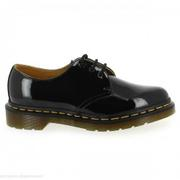

In [7]:
product_search_client = vision.ProductSearchClient()
image = product_search_client.get_reference_image(name="projects/pod-fr-retail/locations/europe-west1/products/2535513/referenceImages/1000010551-2535513-0")
display(get_image(image.uri))